In [1]:
import torch
import torchvision
import numpy as np

from benchmark import ImageBenchmark

In [2]:
bench = ImageBenchmark()
models = list(bench.list_models())
for i, model in enumerate(models):
    if not model.torch_model_exists():
        continue
    print(f'{i}\t {model.__str__()}')
#     if 'quantize' in model.__str__():
#         continue
#     acc = model.accuracy if model.dataset_id != 'ImageNet' else '-'
#     print(f'{i}\t {model.__str__()} {acc}')

0	 pretrain(mbnetv2,ImageNet)-
1	 pretrain(resnet18,ImageNet)-
2	 train(mbnetv2,MIT67)-
3	 train(mbnetv2,Flower102)-
4	 train(mbnetv2,SDog120)-
5	 train(resnet18,MIT67)-
6	 train(resnet18,Flower102)-
7	 train(resnet18,SDog120)-
8	 pretrain(mbnetv2,ImageNet)-transfer(MIT67,0.1)-
9	 pretrain(mbnetv2,ImageNet)-transfer(MIT67,0.5)-
10	 pretrain(mbnetv2,ImageNet)-transfer(MIT67,1)-
11	 pretrain(mbnetv2,ImageNet)-transfer(Flower102,0.1)-
12	 pretrain(mbnetv2,ImageNet)-transfer(Flower102,0.5)-
13	 pretrain(mbnetv2,ImageNet)-transfer(Flower102,1)-
14	 pretrain(mbnetv2,ImageNet)-transfer(SDog120,0.1)-
15	 pretrain(mbnetv2,ImageNet)-transfer(SDog120,0.5)-
16	 pretrain(mbnetv2,ImageNet)-transfer(SDog120,1)-
17	 pretrain(resnet18,ImageNet)-transfer(MIT67,0.1)-
18	 pretrain(resnet18,ImageNet)-transfer(MIT67,0.5)-
19	 pretrain(resnet18,ImageNet)-transfer(MIT67,1)-
20	 pretrain(resnet18,ImageNet)-transfer(Flower102,0.1)-
21	 pretrain(resnet18,ImageNet)-transfer(Flower102,0.5)-
22	 pretrain(resnet18,I

In [3]:
from modeldiff import ModelDiff

def compare_with_seed(model1, model2, truth=-1):
    print(f'comparing:\n  model1={model1}\n  model2={model2}')
    md = ModelDiff(model1, model2)
    seed_inputs = md.get_seed_inputs(rand=False)
    sim = md.compute_similarity_with_inputs(seed_inputs)
    if truth == -1:
        truth = 1 if model1.__str__().split('-')[0] == model2.__str__().split('-')[0] else 0
    print(f' similarity is {sim}, truth is {truth}')

def test(compare):
#     compare(models[23], models[38], 1) # should be similar
    compare(models[1], models[0], 0)   # should be different
    compare(models[13], models[25], 0) # should be different
    compare(models[13], models[22], 0) # should be different
    compare(models[1], models[17], 1)  # should be similar
    compare(models[16], models[13], 1) # should be similar
    compare(models[13], models[12], 1) # should be similar
    
# test(compare_with_seed)

In [4]:
DEVICE = 'cuda'

def gen_adv_inputs(model, inputs):
    from advertorch.attacks import LinfPGDAttack
    def myloss(yhat, y):
        return -((yhat[:,0]-y[:,0])**2 + 0.1*((yhat[:,1:]-y[:,1:])**2).mean(1)).mean()
        
    model = model.to(DEVICE)
    inputs = torch.from_numpy(inputs).to(DEVICE)
    with torch.no_grad():
        model.eval()
        clean_outputs = model(inputs)
    
    output_shape = clean_outputs.shape
    batch_size = output_shape[0]
    num_classes = output_shape[1]
    
    y = torch.zeros(size=output_shape).to(DEVICE)
    y[:, 0] = 1000
    # more diversity
#     rand_idx = torch.randint(low=0, high=num_classes, size=(batch_size,))
#     y = torch.nn.functional.one_hot(rand_idx, num_classes=num_classes).to(DEVICE) * 10
#     print(y)
    
    adversary = LinfPGDAttack(
        model, loss_fn=myloss, eps=0.1,
        nb_iter=40, eps_iter=0.01, 
        rand_init=True, clip_min=-2.2, clip_max=2.2,
        targeted=False
    )
    
    adv_inputs = adversary.perturb(inputs, y)
    
    with torch.no_grad():
        model.eval()
        adv_outputs = model(adv_inputs).to('cpu').numpy()
#     print(adv_outputs)
    torch.cuda.empty_cache()
    return adv_inputs.to('cpu').numpy()

def compare_with_adv(model1, model2, truth=-1):
    print(f'comparing:\n  model1={model1}\n  model2={model2}')
    md = ModelDiff(model1, model2)
    rand = False
    seed_inputs1 = model1.get_seed_inputs(100, rand=rand)
    seed_inputs2 = model2.get_seed_inputs(100, rand=rand)
    seed_inputs = np.concatenate([seed_inputs1, seed_inputs2])
    
    adv_inputs1 = gen_adv_inputs(model1.torch_model, seed_inputs1)
    adv_inputs2 = gen_adv_inputs(model2.torch_model, seed_inputs2)
    adv_inputs = np.concatenate([adv_inputs1, adv_inputs2])
    
    adv_inputs_shuffle = list(adv_inputs)
    np.random.shuffle(adv_inputs_shuffle)
    adv_inputs_shuffle = np.array(adv_inputs_shuffle)
    
    sim = md.compute_similarity_with_inputs(adv_inputs_shuffle)
    if truth == -1:
        truth = 1 if model1.__str__().split('-')[0] == model2.__str__().split('-')[0] else 0
    print(f' similarity is {sim}, truth is {truth}')
    
    ddv_clean = md.compute_ddv(model1, seed_inputs)
    ddv_adv = md.compute_ddv(model1, adv_inputs)
    ddv_advshuf = md.compute_ddv(model1, adv_inputs_shuffle)
    print(f' ddv_clean={ddv_clean}\n ddv_adv={ddv_adv}\n ddv_advshuf={ddv_advshuf}')
    
#     batch_outputs1 = model1.batch_forward(adv_inputs)
#     _, batch_preds1 = batch_outputs1.to('cpu').data.max(1)
#     batch_outputs2 = model2.batch_forward(adv_inputs)
#     _, batch_preds2 = batch_outputs2.to('cpu').data.max(1)
#     print(f'  batch_preds1={batch_preds1}\n  batch_preds2={batch_preds2}')


# compare_with_adv(models[1], models[17], 1)
test(compare_with_adv)

comparing:
  model1=pretrain(resnet18,ImageNet)-
  model2=pretrain(mbnetv2,ImageNet)-
 similarity is 0.8023968022586004, truth is 0
 ddv_clean=[0.26981908 0.4286018  0.33306199 0.514521   0.31118286 0.16915929
 0.60008818 0.20401222 0.54054299 0.11892736 0.22949106 0.14308524
 0.19329977 0.42057496 0.24151164 0.22974586 0.28285128 0.31677538
 0.68129531 0.34811795 0.47133917 0.45122582 0.1804291  0.41371411
 0.15610713 0.09527588 0.17585981 0.30554485 0.27843392 0.20388776
 0.52238148 0.29715329 0.59214211 0.41059172 0.39819396 0.33804786
 0.48850268 0.26363969 0.25628597 0.58303559 0.15343779 0.15103233
 0.25690031 0.59873033 0.38670462 1.05873272 0.35132885 0.45497531
 0.082973   0.23075169 0.42537636 0.47271371 0.3692081  0.52929151
 0.19377273 0.15284234 0.44950593 0.48254919 0.49954468 0.36547357
 0.45334584 0.88296879 0.17457342 0.46854013 0.3100915  0.34051394
 0.33140838 0.19140512 0.32655543 0.1561166  0.51174691 0.30757135
 0.26687974 0.37977141 0.19013363 0.12233776 0.210927

 similarity is 0.6917931968856089, truth is 1
 ddv_clean=[0.23165649 0.55614731 0.23865795 0.74159643 0.60154998 0.35323989
 0.22482574 0.18710011 0.41820794 0.6685802  0.4433285  0.19430888
 0.47229904 0.38708687 0.41091806 0.23033893 0.28653395 0.30965763
 0.12403589 0.11233324 0.53928065 0.28892249 0.21685636 0.26703483
 0.14091307 0.26204032 0.25128484 0.5680581  0.13165748 0.27716726
 0.20544505 0.58981588 0.17820996 0.34716231 0.22413808 0.28553861
 0.46238899 0.25626546 0.19117963 0.24833465 0.48398387 0.40244687
 0.1654979  0.3700074  0.238859   0.31803757 0.25572866 0.34721291
 0.15176207 0.55871269 0.32576799 0.2881934  0.37449008 0.39988881
 0.25679296 0.29104364 0.33585542 0.33089572 0.52715674 0.23403084
 0.21997887 0.12166923 0.15787095 0.58116764 0.59636807 0.34896129
 0.48303765 0.26717997 0.40948755 0.19421607 0.33787674 0.23826051
 0.61121944 0.34144241 0.43916321 0.29548365 0.15707362 0.172822
 0.16358805 0.23189038 0.57926941 0.38527751 0.48291123 0.55906516
 0.3535

In [5]:
from utils import Utils
from matplotlib import pyplot as plt

def show_images(images, labels, title='examples'):
    images = np.transpose(images, (0, 2, 3, 1))
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(hspace=0.2)
    for n in range(25):
        plt.subplot(5,5,n+1)
        img = images[n]
        img = img.squeeze()
        plt.imshow(img)
        plt.title(f'{labels[n]}')
        plt.axis('off')
    _ = plt.suptitle(title)
    plt.show()

# show_images(seed_inputs, list(range(seed_inputs.shape[0])))
# print(seed_inputs[0])
# batch_outputs1 = model1.batch_forward(seed_inputs)
# batch_preds1 = batch_outputs1.to('cpu').data.max(1)
# print(batch_preds1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([-0.1956,  0.4462,  1.6525, -1.8070,  1.1579, -2.3753, -2.0830,  1.9196,
         0.9150, -2.1880, -2.7661,  0.9543, -1.3957,  3.2873, -2.8305, -1.5874,
         1.1672,  4.0923, -2.4381, -0.1481, -1.7900, -2.0508,  2.5372, -3.7372,
         6.3749, -1.2623, -0.5209, -0.2353, -2.8968, -2.4220,  1.2649,  5.8817,
         0.8527,  0.0161, -2.5387,  0.9635,  3.7738, -1.3581,  1.7163, -2.2462,
         3.4503,  0.1685,  0.3789,  0.4516, -0.1801,  2.4340,  0.1609, -1.7000,
         0.5994,  0.5445, -2.0389, -2.5763, -2.3307, -1.2874,  3.5737, -1.2465,
         0.0844, -1.1206, -0.1555, -0.9292,  0.0862, -2.1645,  1.8131, -1.1418,
         6.9132,  1.0771, -3.0021], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

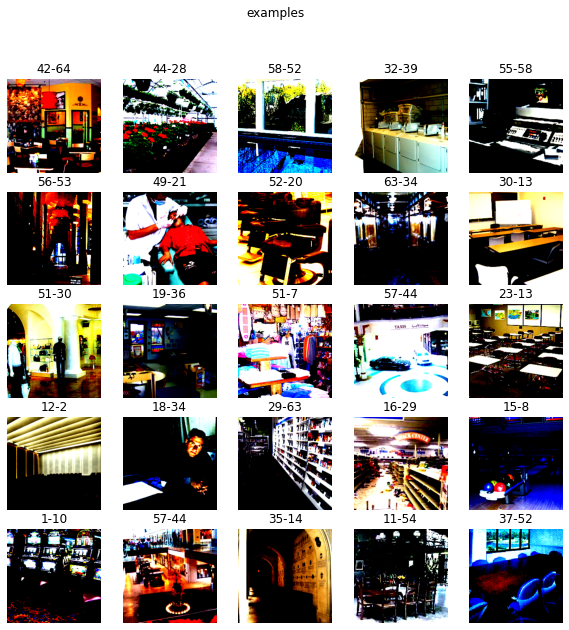

In [6]:
m = models[2]
mm = m.torch_model_on_device
test_loader = m.benchmark.get_dataloader(m.dataset_id, split='test')

# with torch.no_grad():
#     mm.eval()
#     total = 0
#     top1 = 0
#     for i, (batch, label) in enumerate(test_loader):
#         batch, label = batch.to(DEVICE), label.to(DEVICE)
#         total += batch.size(0)
#         out = mm(batch)
#         _, pred = out.max(dim=1)
#         top1 += int(pred.eq(label).sum().item())

# acc = float(top1) / total * 100
# print(top1, total, acc)

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        if i != 10:
            continue
        images, labels = images.cuda(), labels.cuda()
        outputs = mm(images)
        _, preds = outputs.max(dim=1)
        print(outputs[0])
        labels = [f'{label}-{preds[i]}' for i,label in enumerate(list(labels))]
        show_images(images.to('cpu').numpy(), labels)
        break

In [7]:
from model.fe_mobilenet import mbnetv2_dropout
import os

torch_model = mbnetv2_dropout(
            pretrained=False,
            num_classes=67
        )
ckpt = torch.load(os.path.join('models', 'train(mbnetv2,MIT67)-', 'ckpt.pth'))
torch_model.load_state_dict(ckpt['state_dict'])
mm = 

SyntaxError: invalid syntax (<ipython-input-7-2dc150d402ff>, line 10)